`python3 export.py --weights weights/yolov7-mask.pt --img-size 640 640 --batch-size 1 --grid --end2end --max-wh 640 --simplify --mask --cleanup --topk-all 100 --iou-thres 0.65 --conf-thres 0.35`

In [1]:
import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict, namedtuple

In [2]:
cuda = False
w = "../weights/yolov7-mask.onnx"
img = cv2.imread("../inference/images/bus.jpg")

In [3]:
providers = (
    ["CUDAExecutionProvider", "CPUExecutionProvider"]
    if cuda
    else ["CPUExecutionProvider"]
)
session = ort.InferenceSession(w, providers=providers)

In [4]:
def letterbox(
    im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32
):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(
        im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )  # add border
    return im, r, (dw, dh)

In [5]:
names = [
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "backpack",
    "umbrella",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "dining table",
    "toilet",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]

In [6]:
colors = {
    name: [random.randint(0, 255) for _ in range(3)] for i, name in enumerate(names)
}

In [7]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255
im.shape

(1, 3, 640, 640)

In [8]:
outname = [i.name for i in session.get_outputs()]
print(outname)

inname = [i.name for i in session.get_inputs()]
print(inname)

['output']
['images']


In [9]:
inp = {inname[0]: im}

In [10]:
# ONNX inference
outputs = session.run(outname, inp)[0]
outputs.shape

(5, 3143)

In [11]:
import torch

b_idxs = torch.tensor(outputs[:, 0])
bbox = torch.tensor(outputs[:, 1:5])
cls = torch.tensor(outputs[:, 5])
conf = torch.tensor(outputs[:, 6])
pred_masks = torch.tensor(outputs[:, 7:].reshape(-1, 56, 56))

print(
    bbox.shape,
    conf.shape,
    cls.shape,
    pred_masks.shape,
)

/home/jovyan/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([5, 4]) torch.Size([5]) torch.Size([5]) torch.Size([5, 56, 56])


In [12]:
cls

tensor([0., 5., 0., 0., 0.])

In [13]:
from detectron2.layers import paste_masks_in_image
from detectron2.modeling.poolers import ROIPooler
from detectron2.structures import Boxes
from detectron2.utils.memory import retry_if_cuda_oom

In [14]:
image = torch.tensor(im)
image.shape

torch.Size([1, 3, 640, 640])

In [15]:
nb, _, height, width = image.shape

In [16]:
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
# nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)

In [17]:
pnimg = nimg.copy()

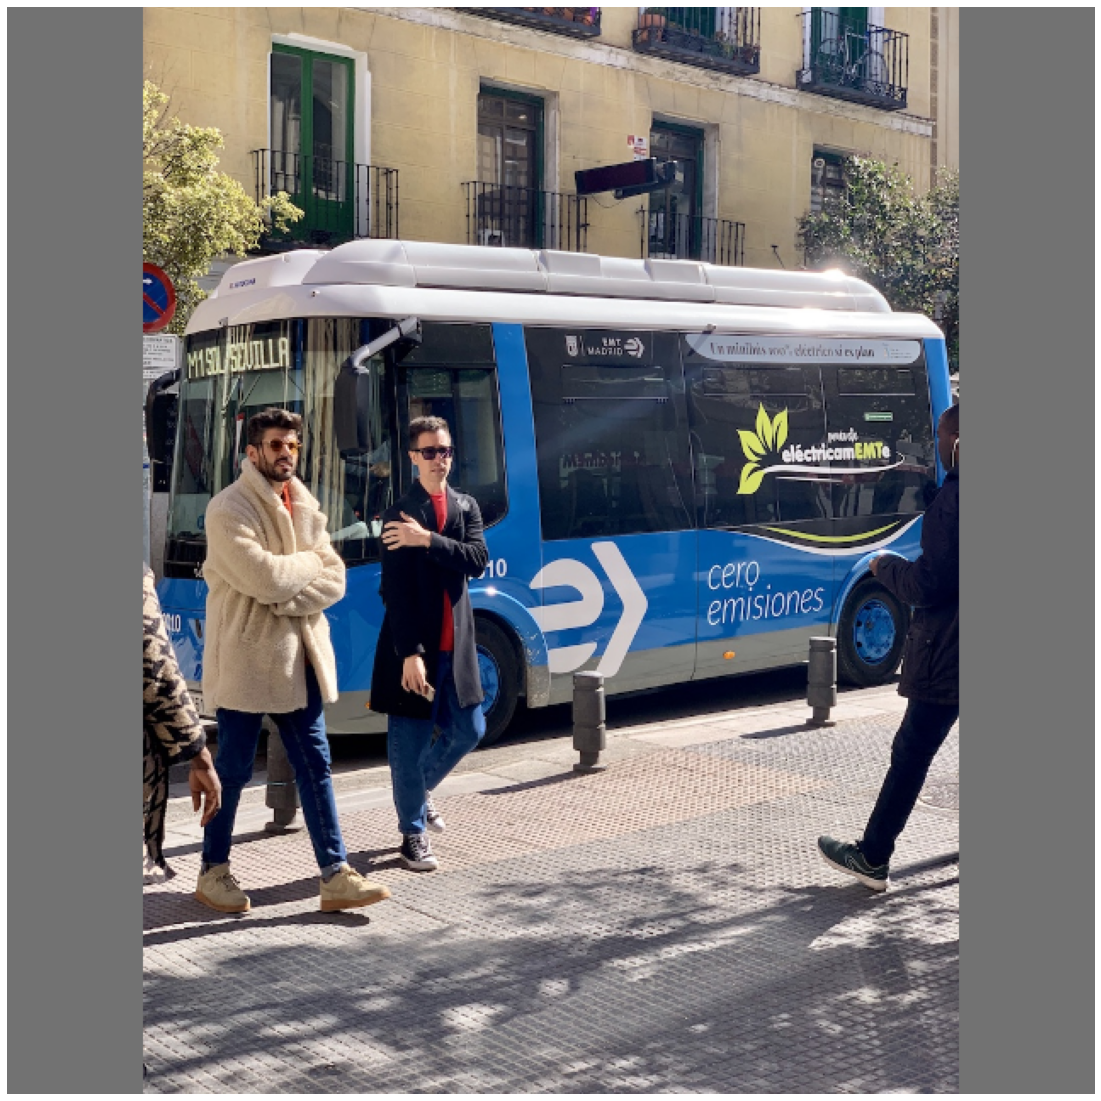

In [18]:
import matplotlib.pyplot as plt

# coco example
%matplotlib inline
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(pnimg)
plt.show()

In [19]:
bboxes = Boxes(bbox)

pred_masks = retry_if_cuda_oom(paste_masks_in_image)(
    pred_masks, bboxes, (height, width), threshold=0.5
)
pred_masks_np = pred_masks.detach().cpu().numpy()

pred_cls = cls.detach().cpu().numpy()
pred_conf = conf.detach().cpu().numpy()

nbboxes = bboxes.tensor.detach().cpu().numpy().astype(np.int)

In [20]:
for one_mask, bbox, cls, conf in zip(pred_masks_np, nbboxes, pred_cls, pred_conf):
    if conf < 0.25:
        continue

    color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

    pnimg[one_mask] = pnimg[one_mask] * 0.5 + np.array(color, dtype=np.uint8) * 0.5
    # pnimg = cv2.rectangle(pnimg, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)

    label = "%s %.3f" % (names[int(cls)], conf)
    t_size = cv2.getTextSize(label, 0, fontScale=0.5, thickness=1)[0]
    # c2 = bbox[0] + t_size[0], bbox[1] - t_size[1] - 3
    # # pnimg = cv2.rectangle(pnimg, (bbox[0], bbox[1]), c2, color, -1, cv2.LINE_AA)  # filled
    pnimg = cv2.putText(
        pnimg,
        label,
        (bbox[0], bbox[1] - 2),
        0,
        0.5,
        [255, 255, 255],
        thickness=1,
        lineType=cv2.LINE_AA,
    )

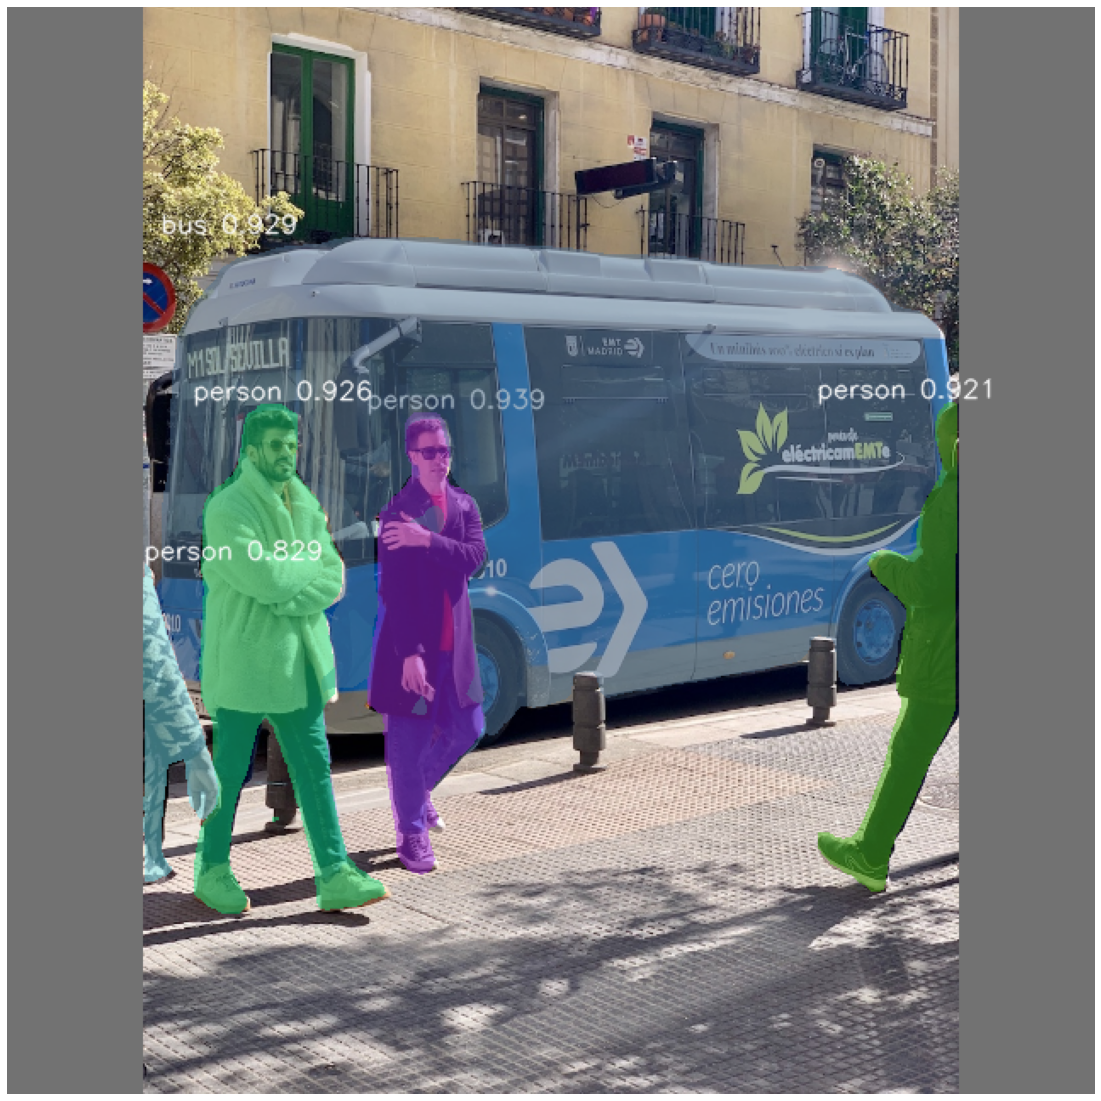

In [21]:
import matplotlib.pyplot as plt

# coco example
%matplotlib inline
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(pnimg)
plt.show()